In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import Env
from gymnasium.spaces import Discrete
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
from PIL import Image

class TreasureHuntEnv(Env):
    def __init__(self,max_timesteps):
        self.action_space = Discrete(4)  
        self.observation_space = Discrete(25)
        self.max_timesteps = max_timesteps
        self.cumulative_reward = 0
        self.grid_size = (5,5)
        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4]
        self.timestep = 0
        self.state = np.zeros(self.grid_size)
        self.treasures = [(0,3),(2, 3)] 
        self.traps = [(1, 0), (1, 3),(3,3)] 
        self.loadRewards()
        self.frames = []
        
        

    def reset(self):
        self.loadRewards()
        self.agent_pos = [0, 0]  
        self.timestep = 0
        self.cumulative_reward = 0
        self.state[tuple(self.agent_pos)] = 15
        observation = self.state.flatten()
        return self.agent_pos, observation

    def step(self, action):    
        if action == 0:  # Up
            self.agent_pos[0] -= 1
        elif action == 1:  # Right
            self.agent_pos[1] += 1
        elif action == 2:  # Down
            self.agent_pos[0] += 1
        elif action == 3:  # Left
            self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size[0] - 1)
        self.timestep += 1

        reward=self.addRewards()
        self.cumulative_reward += reward

        terminated = tuple(self.agent_pos) == tuple(self.goal_pos)
        if self.max_timesteps > 0: #truncating if timestep is given
            truncated = self.timestep >= self.max_timesteps
        else:
            truncated = False

        self.loadRewards()
        self.state[tuple(self.agent_pos)] = 15
        observation = self.state.flatten()

        info = {}
        return self.agent_pos, reward, terminated, truncated,observation,info

    # def render(self): 
    #     plt.imshow(self.state)
    #     plt.show()
    
    def loadRewards(self):
        self.state = np.zeros(self.grid_size)
        for t in self.treasures:
            self.state[t] = 5
        for tr in self.traps:
            self.state[tr] = -5 
        self.state[tuple(self.goal_pos)] = 10

    def addRewards(self):
        if tuple(self.agent_pos) == tuple(self.goal_pos):
            reward = 100 
        elif tuple(self.agent_pos) in self.treasures:
            reward = 20 
            # self.treasures.remove(tuple(self.agent_pos)) # remove the treasure once collected
        elif tuple(self.agent_pos) in self.traps:
            reward = -20
        else:
            reward = -0.5
        return reward
    
    def render(self ,plot=False,save_gif=False):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)

        def plot_image(plot_pos):
            plot_agent, plot_trap, plot_treasure, plot_goal =  False, False, False, False
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            if len(self.treasures) > 0 and any(np.array_equal(self.treasures[i], plot_pos) for i in range(len(self.treasures))):
                plot_treasure = True
            if any(np.array_equal(self.traps[i], plot_pos) for i in range(len(self.traps))):
                plot_trap = True
            if np.array_equal(plot_pos, self.goal_pos):
                plot_goal = True

            if plot_agent and \
                    all(not item for item in
                        [plot_trap, plot_treasure, plot_goal]):
                agent = AnnotationBbox(OffsetImage(plt.imread('./images/AGENT.png'), zoom=0.18),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

            elif plot_trap and \
                    all(not item for item in
                        [plot_agent, plot_treasure, plot_goal]):
                breeze = AnnotationBbox(OffsetImage(plt.imread('./images/TRAP.png'), zoom=0.18),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(breeze)

            elif plot_treasure and \
                    all(not item for item in
                        [plot_agent, plot_trap, plot_goal]):
                gold = AnnotationBbox(OffsetImage(plt.imread('./images/TREASURE.png'), zoom=0.18),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(gold)

            elif plot_goal and \
                    all(not item for item in
                        [plot_agent, plot_treasure, plot_trap]):
                pit = AnnotationBbox(OffsetImage(plt.imread('./images/GOAL.png'), zoom=0.18),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pit)

            elif all(item for item in [plot_agent, plot_treasure]) and \
                    all(not item for item in
                        [plot_trap, plot_goal]):
                agent_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/AGENT_WITH_TREASURE.png'), zoom=0.18),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_breeze)
                self.treasures.remove(tuple(self.agent_pos)) # remove the treasure once collected

            elif all(item for item in [plot_agent, plot_trap]) and \
                    all(not item for item in
                        [plot_treasure, plot_goal]):
                agent_pit = AnnotationBbox(OffsetImage(plt.imread('./images/AGENT_WITH_TRAP.png'), zoom=0.18),
                                           np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_pit)

            elif all(item for item in [plot_agent, plot_goal]) and \
                    all(not item for item in
                        [plot_treasure, plot_trap]):
                agent_stench = AnnotationBbox(OffsetImage(plt.imread('./images/AGENT_WITH_GOAL.png'), zoom=0.18),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_stench)

        coordinates_state_mapping_2 = {}
        for j in range(self.grid_size[0] * self.grid_size[1]):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.grid_size[0], int(np.floor(j / self.grid_size[1]))])

        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

        plt.xticks([0, 1, 2, 3, 4, 5])
        plt.yticks([0, 1, 2, 3, 4, 5])
        plt.grid()
        
        if save_gif:
            # Convert the figure to an image and add to the frames list
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            img_pil = Image.fromarray(img)
            self.frames.append(img_pil)
            print("Frame added to GIF",len(self.frames))

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 84
            height = 84
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image
        
    def SAVEGIF(self):
        if len(self.frames) == 0:
            print("No frames to save")
            return
        gif_path = './treasure_hunt.gif'
        self.frames[0].save(gif_path, save_all=True, append_images=self.frames[1:], duration=500, loop=0)
        print(f"GIF saved to {gif_path}")


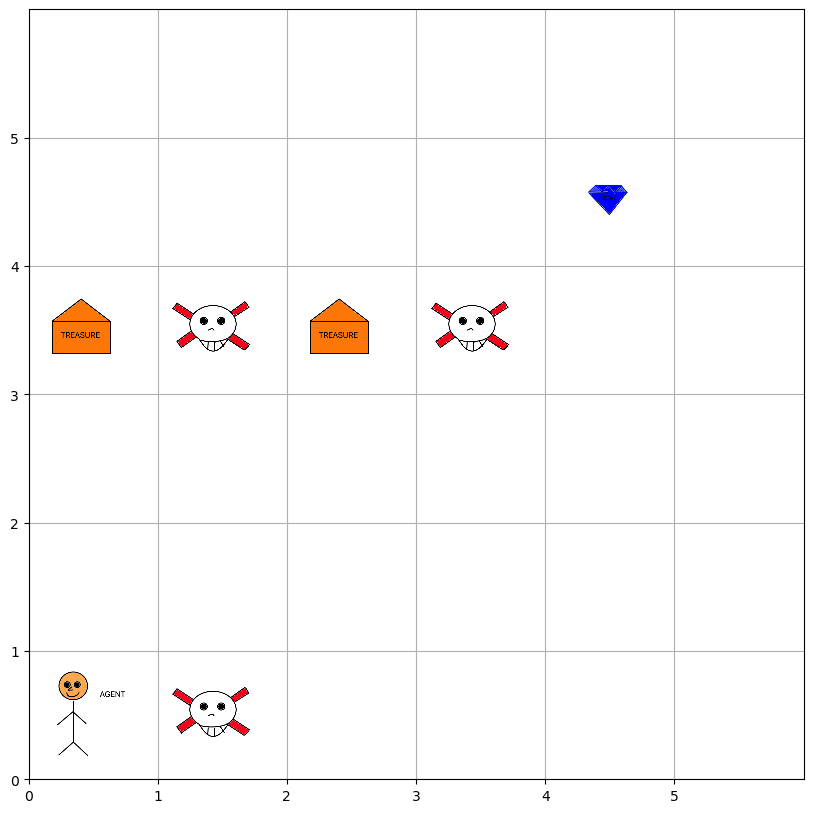

TimeStep no.: 1 , State: [1 0] , Action: 2 , Reward: -20 , Cumulative Reward: -20


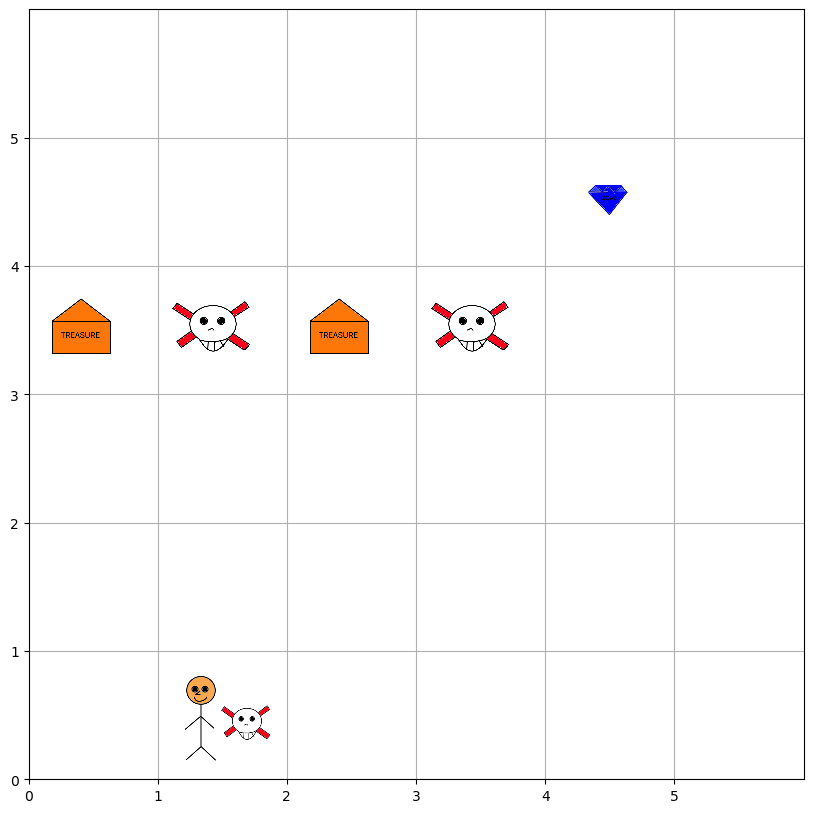

TimeStep no.: 2 , State: [1 0] , Action: 3 , Reward: -20 , Cumulative Reward: -40


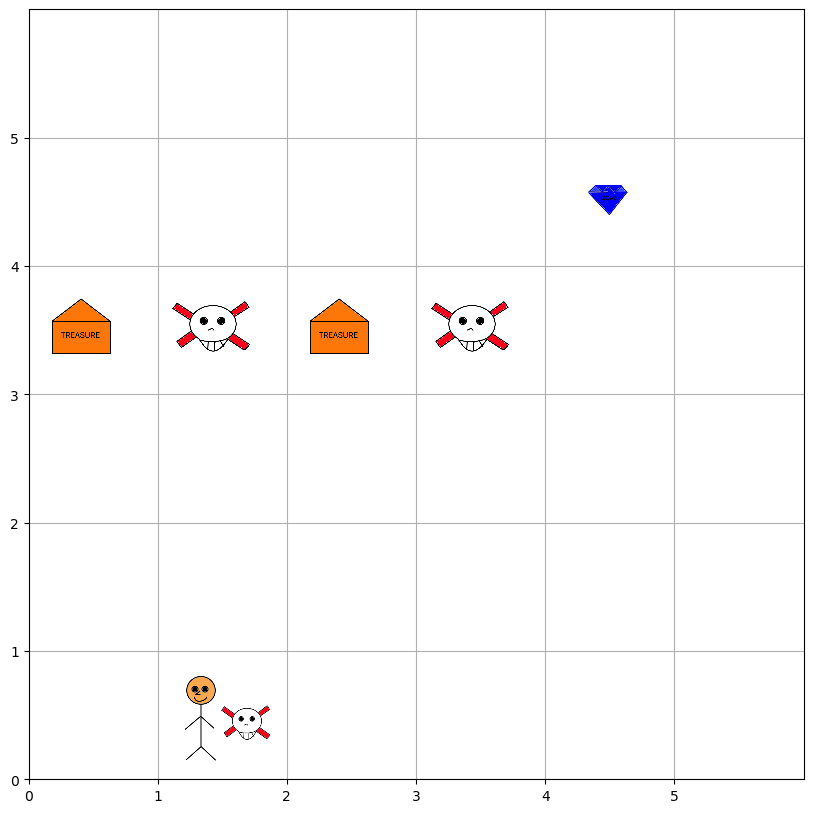

TimeStep no.: 3 , State: [0 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -40.5


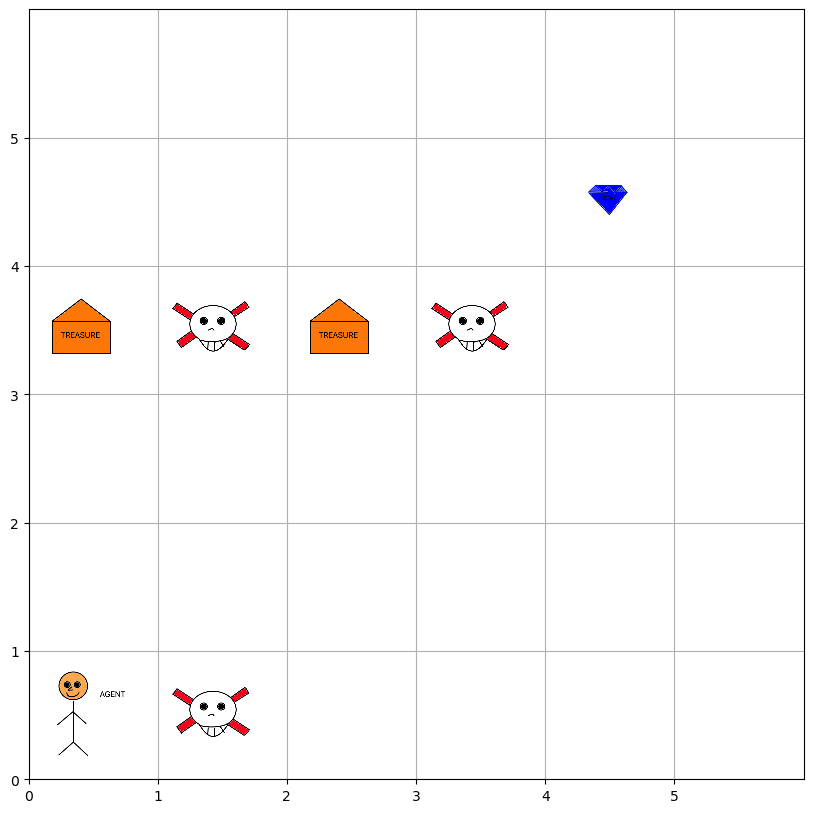

TimeStep no.: 4 , State: [0 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: -41.0


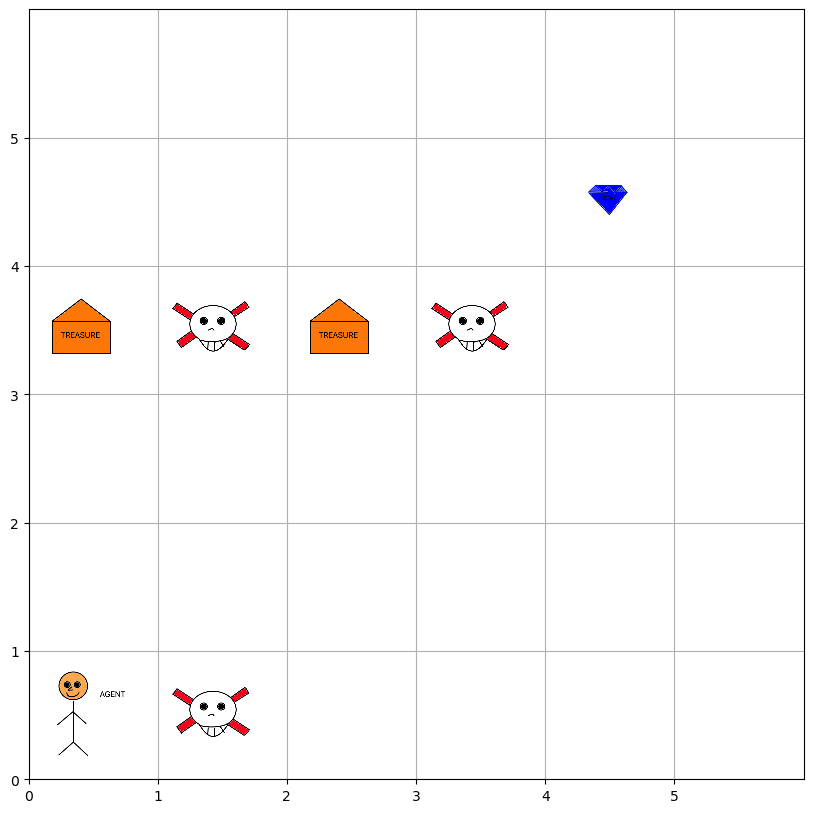

TimeStep no.: 5 , State: [0 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -41.5


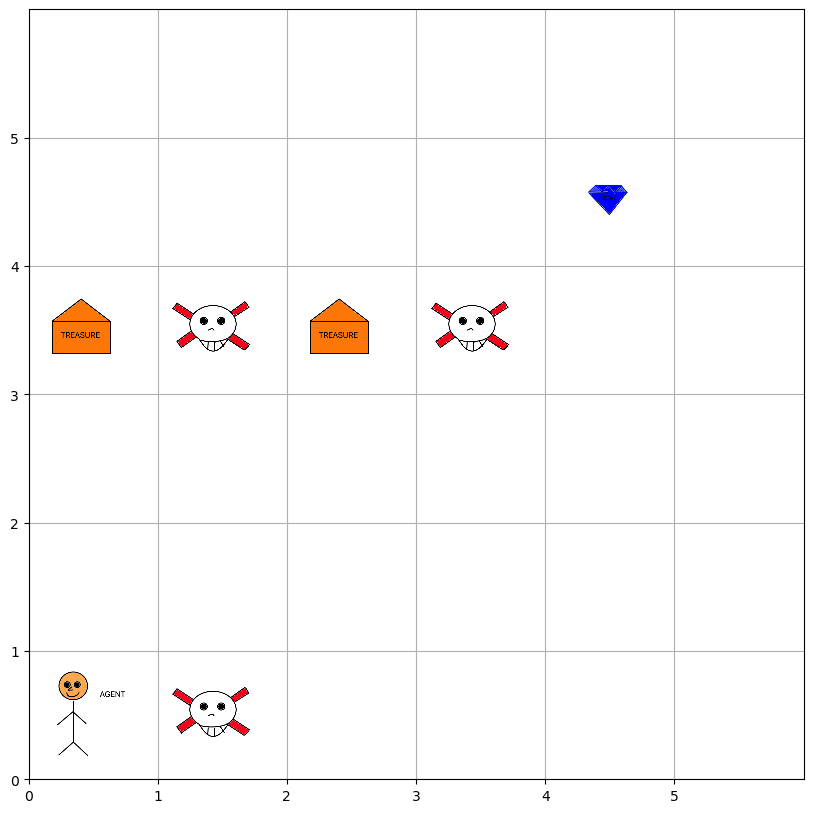

TimeStep no.: 6 , State: [0 1] , Action: 1 , Reward: -0.5 , Cumulative Reward: -42.0


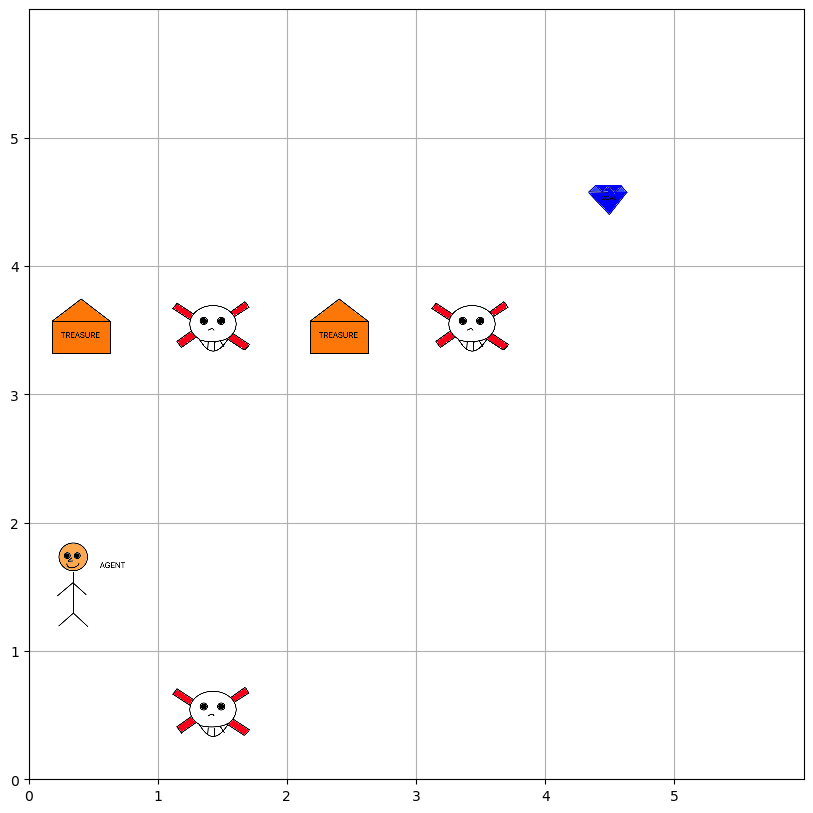

TimeStep no.: 7 , State: [0 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -42.5


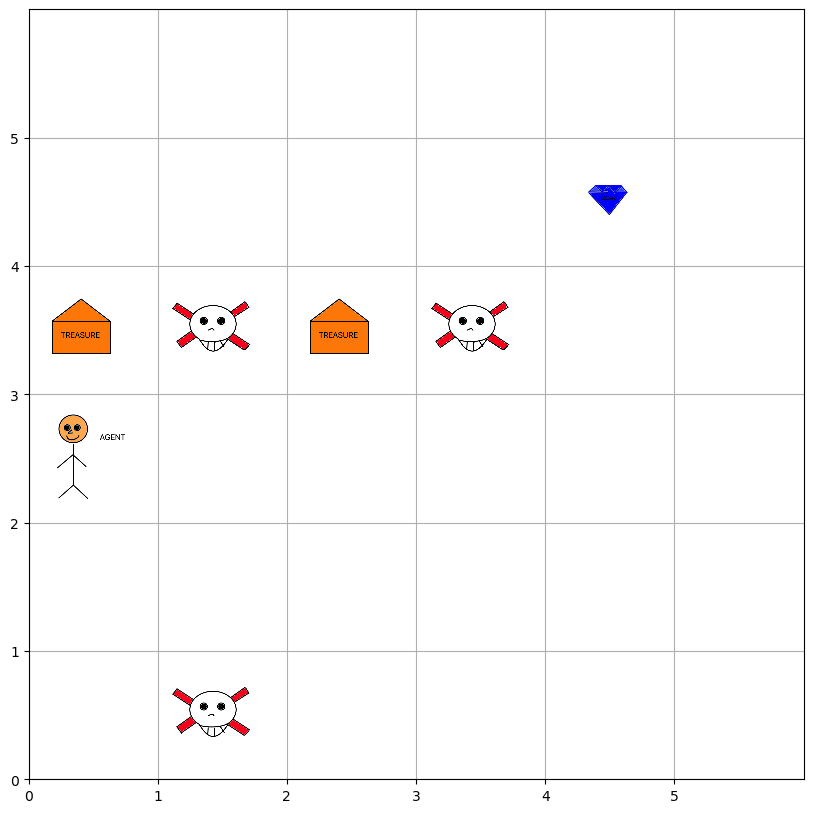

TimeStep no.: 8 , State: [0 1] , Action: 3 , Reward: -0.5 , Cumulative Reward: -43.0


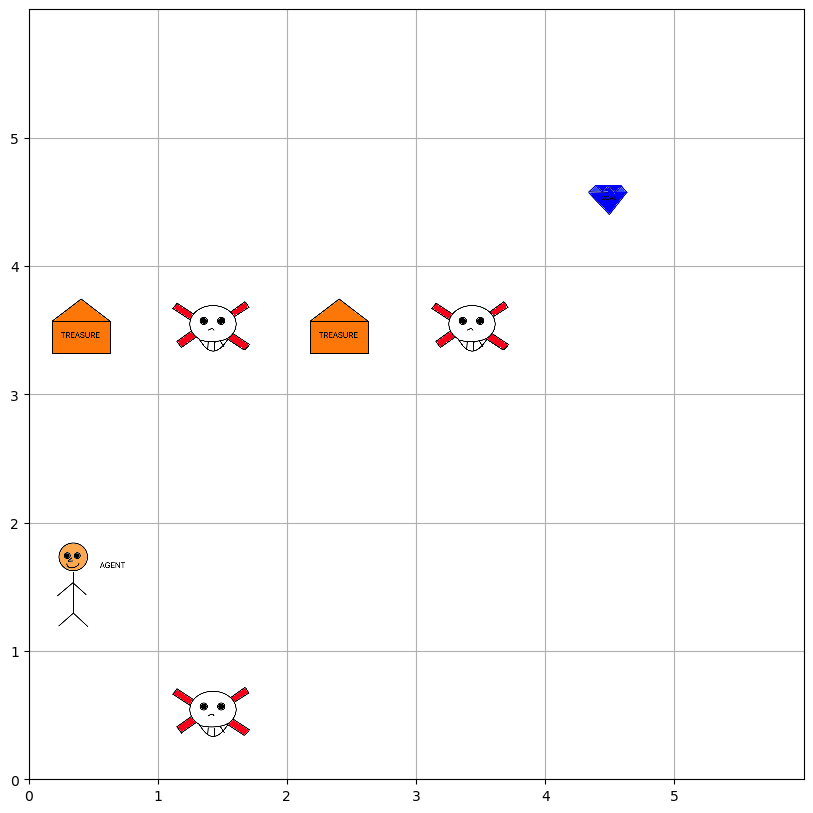

TimeStep no.: 9 , State: [0 1] , Action: 0 , Reward: -0.5 , Cumulative Reward: -43.5


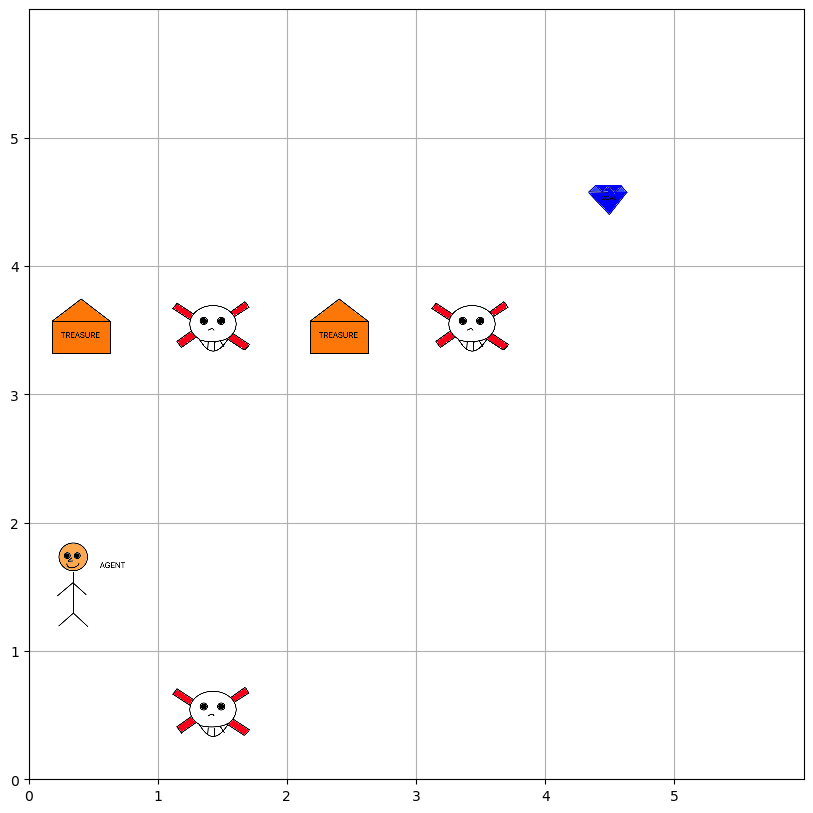

TimeStep no.: 10 , State: [0 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -44.0


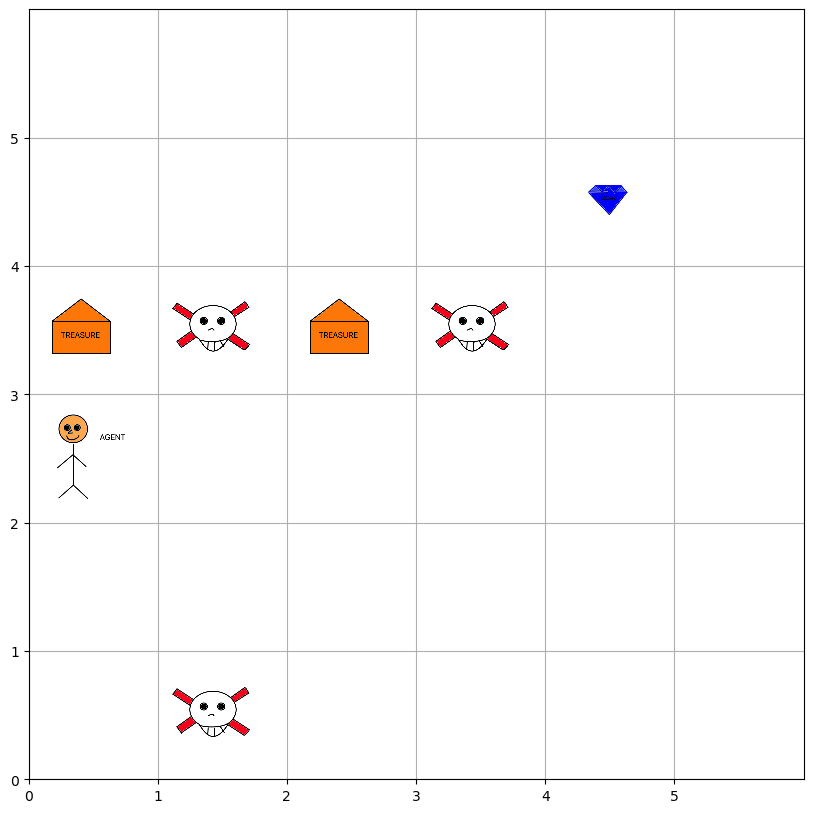

Final Cumulative Reward: -44.0
No frames to save


In [3]:
# Run for a fixed number of timesteps
env = TreasureHuntEnv(max_timesteps=10)
state = env.reset()
env.render(plot=True,save_gif=False)
terminated, truncated, i = False, False, 1
while not terminated and not truncated:
    action = env.action_space.sample()
    state, reward, terminated, truncated, observation, info = env.step(action)
    print("TimeStep no.:",i,", State:",state,", Action:",action,", Reward:",reward,", Cumulative Reward:",env.cumulative_reward)
    env.render(plot=True,save_gif=False)
    i += 1

print(f"Final Cumulative Reward: {env.cumulative_reward}")

env.SAVEGIF()